In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import cv2
import os
from sklearn.preprocessing import MinMaxScaler
import pysptools.eea as eea
 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

In [2]:


# Define the neural network architecture
class UnmixingNet(nn.Module):
    def __init__(self, r, padding):
        super(UnmixingNet, self).__init__()
        self.padding = padding
        self.pad = nn.ReflectionPad2d((0,0,0,0))
        if(padding) :
            self.pad = nn.ReflectionPad2d((1,0,1,0))
        self.conv1 = nn.Conv2d(r, 256, kernel_size=3, stride=2, padding_mode="reflect", padding=1)
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding_mode="reflect", padding=1)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.batch_norm_up = nn.BatchNorm2d(260)
        self.conv3 = nn.Conv2d(260, 256, kernel_size=3, stride=1, padding_mode="reflect", padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding_mode="reflect")
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.leaky_relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.conv5 = nn.Conv2d(256, r, kernel_size=1, stride=1, padding_mode="reflect")
        self.softmax = nn.Softmax(dim=1)
        self.conv_skip = nn.Conv2d(r, 4, kernel_size=1, stride=1, padding_mode="reflect")
        self.batch_norm_skip = nn.BatchNorm2d(4)
        self.leaky_relu_skip = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):

      padded = self.pad(x)
      #print("input size =", padded.size())
      
      conv1_out = self.conv1(padded)
      #print("conv1 =", conv1_out.size())
      
      bn1_out = self.batch_norm1(conv1_out)
      #print("bn1 =", bn1_out.size())
      
      leaky_relu1_out = self.leaky_relu1(bn1_out)
      #print("lrelu1 =", leaky_relu1_out.size())
      
      conv2_out = self.conv2(leaky_relu1_out)
      #print("conv2 =", conv2_out.size())
      
      bn2_out = self.batch_norm2(conv2_out)
      #print("bn2 =", bn2_out.size())
      
      leaky_relu2_out = self.leaky_relu1(bn2_out)
      #print("lrelu2 =", leaky_relu2_out.size())
      
      upsample_out = self.upsample(leaky_relu2_out)
      #print("upsample =", upsample_out.size())
      
      conv_skip_out = self.conv_skip(padded)
      #print("convskip =", conv_skip_out.size())
      
      bn_skip_out = self.batch_norm_skip(conv_skip_out)
      #print("bn_skip =", bn_skip_out.size())
      
      leaky_relu_skip_out = self.leaky_relu1(bn_skip_out)
      #print("lrelu_skip =", leaky_relu_skip_out.size())
      
      conv3_input = self.batch_norm_up(torch.cat((leaky_relu_skip_out, upsample_out), dim=1))
      #print("conv3_input =", conv3_input.size())
      
      conv3_out = self.conv3(conv3_input)
      #print("conv3 =", conv3_out.size())
      
      bn3_out = self.batch_norm3(conv3_out)
      #print("bn3 =", bn3_out.size())
      
      leaky_relu3_out = self.leaky_relu1(bn3_out)
      #print("lrelu3 =", leaky_relu3_out.size())
      
      conv4_out = self.conv4(leaky_relu3_out)
      #print("conv4 =", conv4_out.size())
      
      bn4_out = self.batch_norm4(conv4_out)
      #print("bn4 =", bn4_out.size())
      
      leaky_relu4_out = self.leaky_relu1(bn4_out)
      #print("lrelu4 =", leaky_relu4_out.size())
      
      conv5_out = self.conv5(leaky_relu4_out)
      #print("conv5 =", conv5_out.size())
      
      output = self.softmax(conv5_out)
      #print(output[:,:,1:,1:].size())
      
      if(self.padding) :
        return output[:,:,1:,1:]
      return output






In [3]:
#Choose dataset 0:Urban, 1:Jasper, 2:Samson
def load_dataset(dataset=0):
    if(dataset==0):
        data = sci.loadmat('Data/Urban.mat')
        gt = sci.loadmat('Data/end6_groundTruth.mat')
        X = data['X']
        abundances = gt['A']
        endmembers = gt['M']
        names = ["Road", "Grass", "Tree", "Rooftop", "Metal", "Dirt"]
    if(dataset==1):
        data = sci.loadmat('Data/jasperRidge2_R198.mat')
        gt = sci.loadmat('Data/end4.mat')
        X = data['Y']
        abundances = gt['A']
        endmembers = gt['M']
        names = ["Tree", "Water", "Dirt", "Road"]
    if(dataset==2):
        data = sci.loadmat('Data/Y_clean.mat')
        A_gt = sci.loadmat('Data/A_true.mat')
        E_gt = sci.loadmat('Data/E.mat')
        X = data['Y_clean'].transpose(2,0,1)
        X = X.reshape(X.shape[0], X.shape[1]**2)
        abundances = A_gt['A_true'].transpose(2,0,1)
        abundances = abundances.reshape(abundances.shape[0], abundances.shape[1]**2)
        endmembers = E_gt['E']
        names = ["Water", "Soil", "Tree"]
    p = X.shape[0]
    n = X.shape[1]
    r = endmembers.shape[1]
    X = X.astype(float)
    X = X/np.max(X)
    return X, abundances, endmembers, p, n, r, names

        


X Max: 1.  Min: 0.  Mean: 0.21963278434519914  Std: 0.18978914980898212
Abundance Max: 1.0000000000000002  Min: 0.  Mean: 0.25  Std: 0.3497529508863477
Endmember Max: 0.6290566037735849  Min: 0.  Mean: 0.27023433672857156  Std: 0.19448823614872807
Xhat Max: 0.6290566037735849  Min: 0.  Mean: 0.22948484265564528  Std: 0.17766093984342912


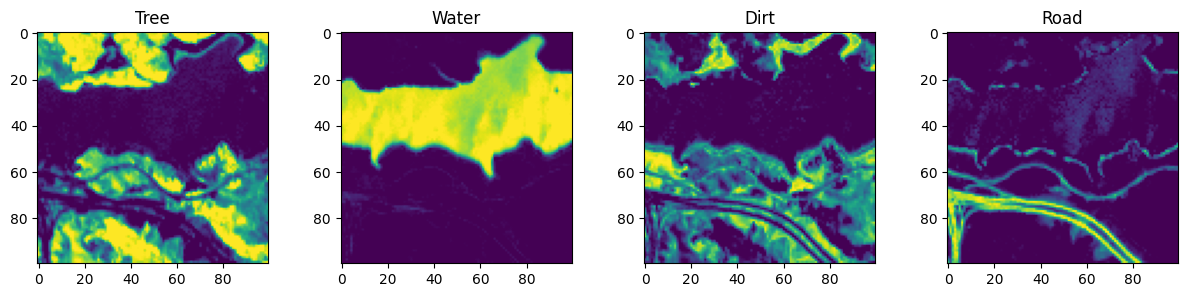

In [4]:
dataset = 1
X, abundances, endmembers, p, n, r, names= load_dataset(dataset)
Xx = endmembers @ abundances


print(f"X Max: {np.format_float_positional(np.max(X))}  Min: {np.format_float_positional(np.min(X))}  Mean: {np.format_float_positional(np.mean(X))}  Std: {np.format_float_positional(np.std(X))}")
print(f"Abundance Max: {np.format_float_positional(np.max(abundances))}  Min: {np.format_float_positional(np.min(abundances))}  Mean: {np.format_float_positional(np.mean(abundances))}  Std: {np.format_float_positional(np.std(abundances))}")
print(f"Endmember Max: {np.format_float_positional(np.max(endmembers))}  Min: {np.format_float_positional(np.min(endmembers))}  Mean: {np.format_float_positional(np.mean(endmembers))}  Std: {np.format_float_positional(np.std(endmembers))}")
print(f"Xhat Max: {np.format_float_positional(np.max(Xx))}  Min: {np.format_float_positional(np.min(Xx))}  Mean: {np.format_float_positional(np.mean(Xx))}  Std: {np.format_float_positional(np.std(Xx))}")

nCol = np.sqrt(n).astype(int)
nRow = np.sqrt(n).astype(int)
plt.figure(figsize=(15, 3))

for ii in range(r): 
    ax = plt.subplot(1, r, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    plt.title(names[ii])


In [5]:
hsi_cube = X.reshape(p,nCol,nRow).transpose(1,2,0)
print(X.shape)

atgp = eea.ATGP()
endmember_atgp = atgp.extract(hsi_cube, r, normalize=True)
endmember_atgp = endmember_atgp.T

nfindr = eea.NFINDR()
endmember_nfindr = nfindr.extract(hsi_cube, r, normalize=True, ATGP_init=False)
endmember_nfindr = endmember_nfindr.T

ppi = eea.PPI()
endmember_ppi = ppi.extract(hsi_cube, r, normalize=True)
endmember_ppi = endmember_ppi.T

fippi = eea.FIPPI()
endmember_fippi = fippi.extract(hsi_cube, r, normalize=True)
endmember_fippi = endmember_fippi.T

(198, 10000)


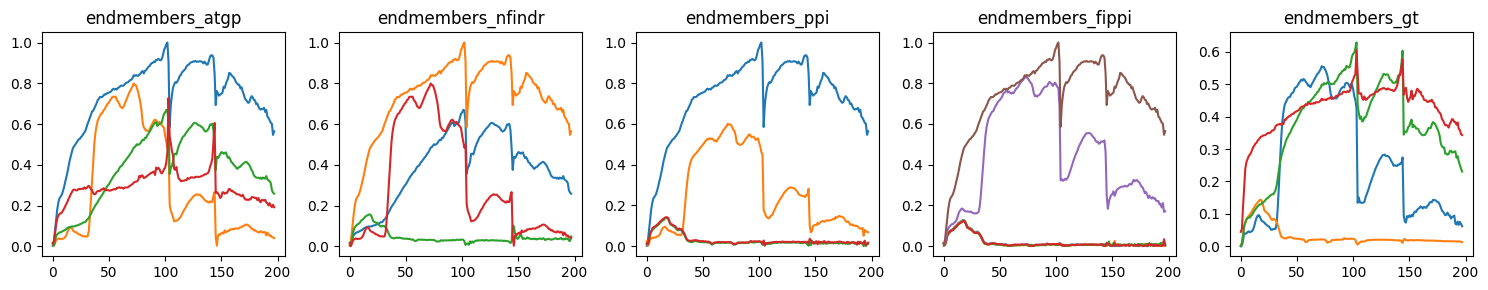

In [6]:
# Create a figure and subplots with a size of 1x5
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Plot each numpy array in its respective subplot
axs[0].plot(endmember_atgp)
axs[0].set_title('endmembers_atgp')

axs[1].plot(endmember_nfindr)
axs[1].set_title('endmembers_nfindr')

axs[2].plot(endmember_ppi)
axs[2].set_title('endmembers_ppi')

axs[3].plot(endmember_fippi)
axs[3].set_title('endmembers_fippi')

axs[4].plot(endmembers)
axs[4].set_title('endmembers_gt')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

torch.Size([198, 10000])
torch.Size([4, 10000])
torch.Size([198, 4])
0.11787104606628418
Epoch: 300/3000, Loss: 0.026288583874702454, mae: 0.36133402585983276


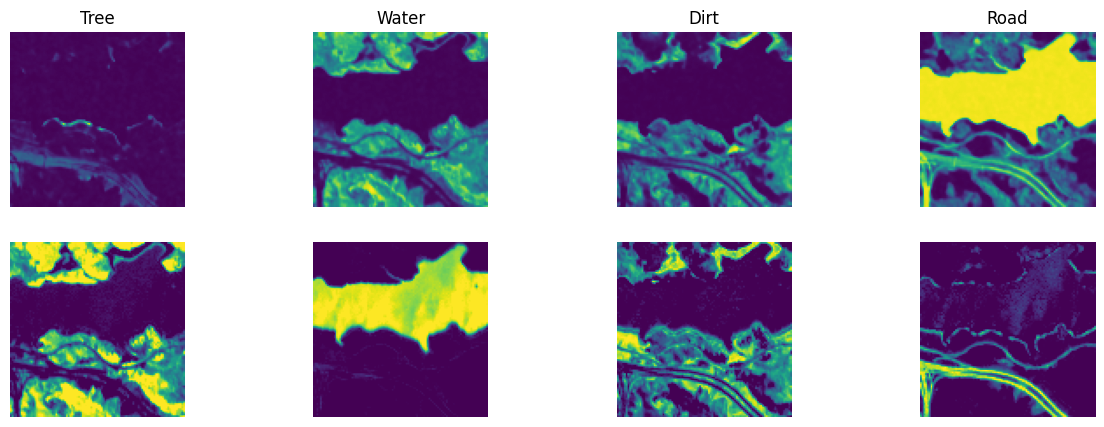

Epoch: 600/3000, Loss: 0.026212135329842567, mae: 0.3697851896286011


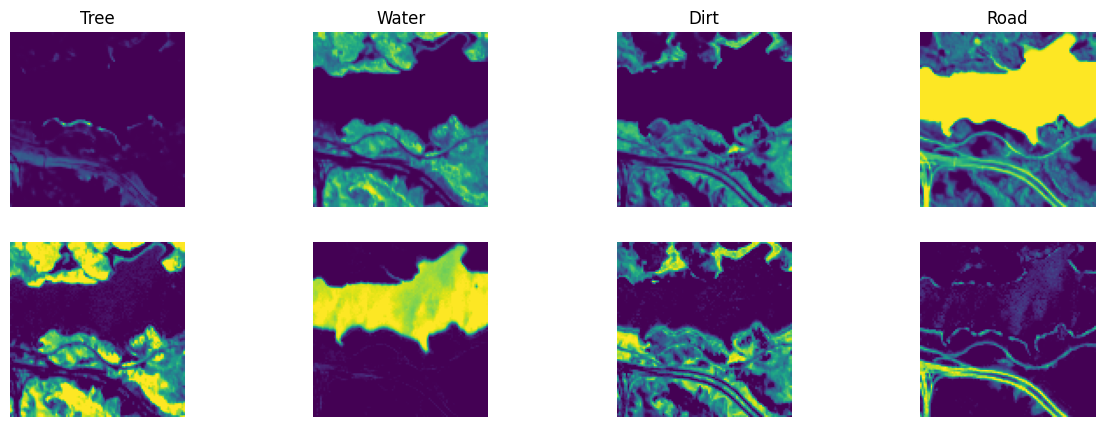

Epoch: 900/3000, Loss: 0.026250295341014862, mae: 0.3708217740058899


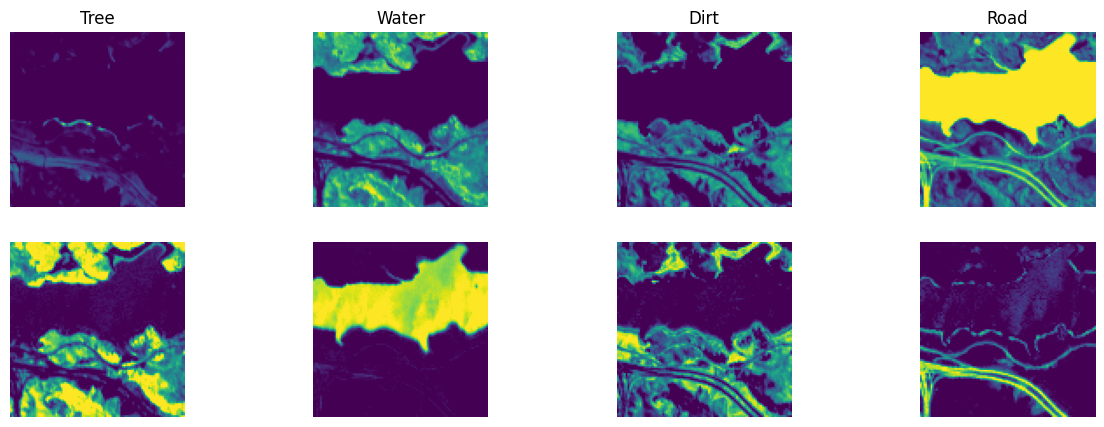

Epoch: 1200/3000, Loss: 0.026164455339312553, mae: 0.3710174262523651


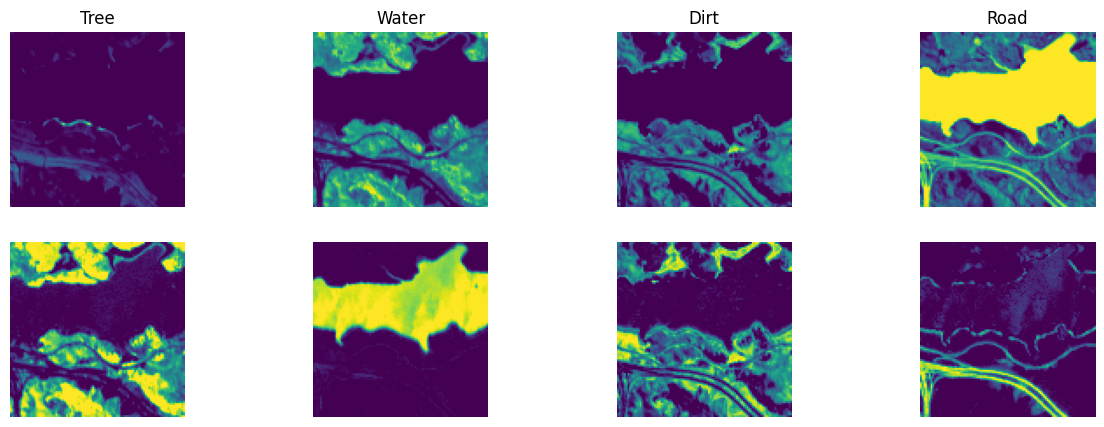

Epoch: 1500/3000, Loss: 0.026162289083003998, mae: 0.37106505036354065


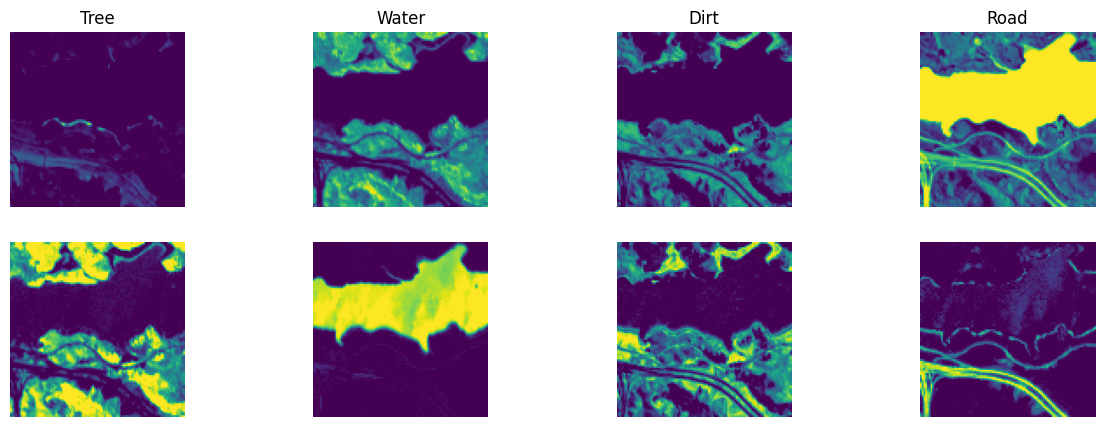

Epoch: 1800/3000, Loss: 0.02615775167942047, mae: 0.3711188733577728


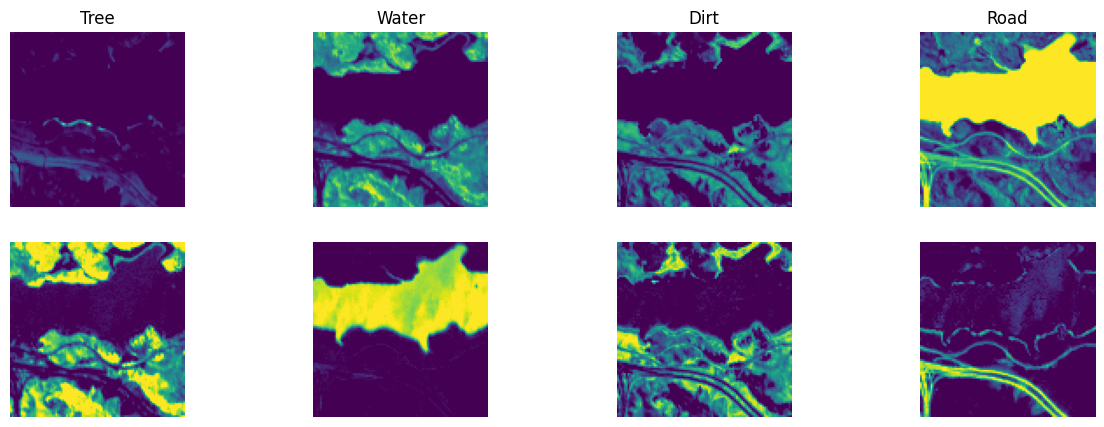

Epoch: 2100/3000, Loss: 0.02615584246814251, mae: 0.3712237477302551


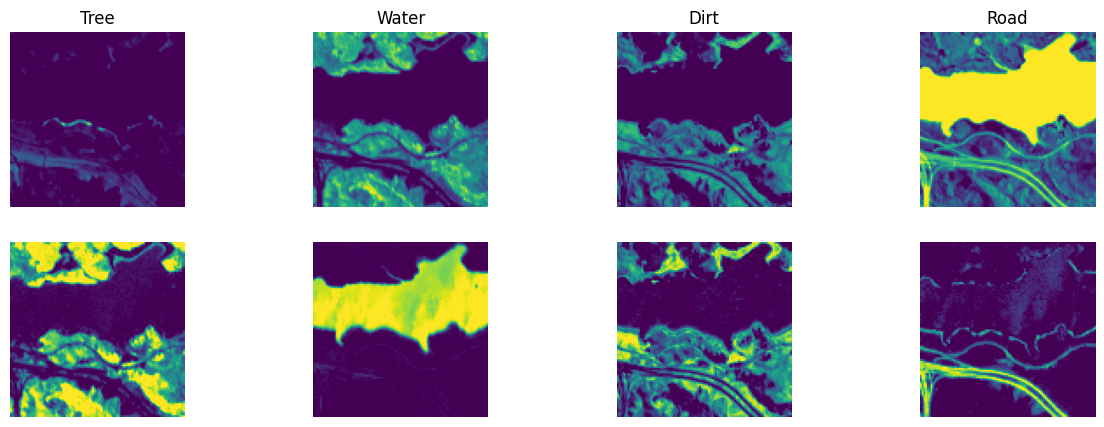

Epoch: 2400/3000, Loss: 0.026154059916734695, mae: 0.37135282158851624


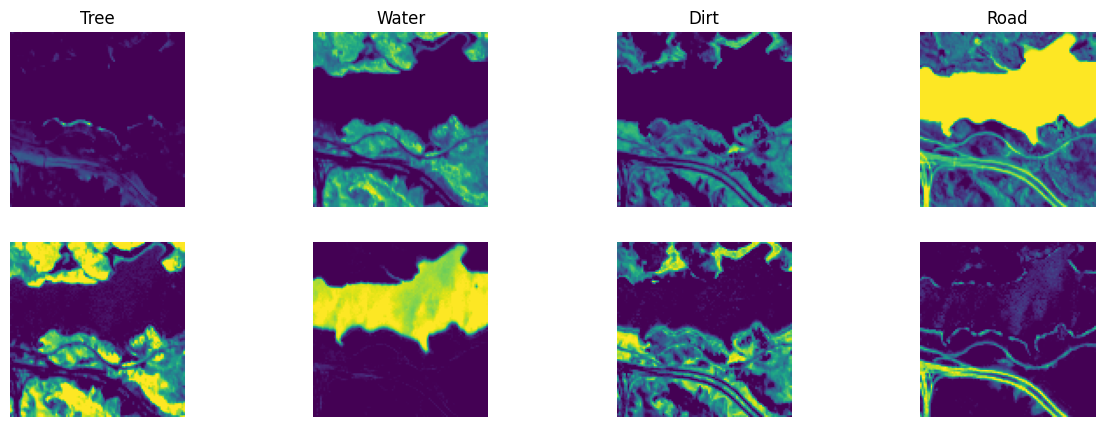

Epoch: 2700/3000, Loss: 0.026153644546866417, mae: 0.37134885787963867


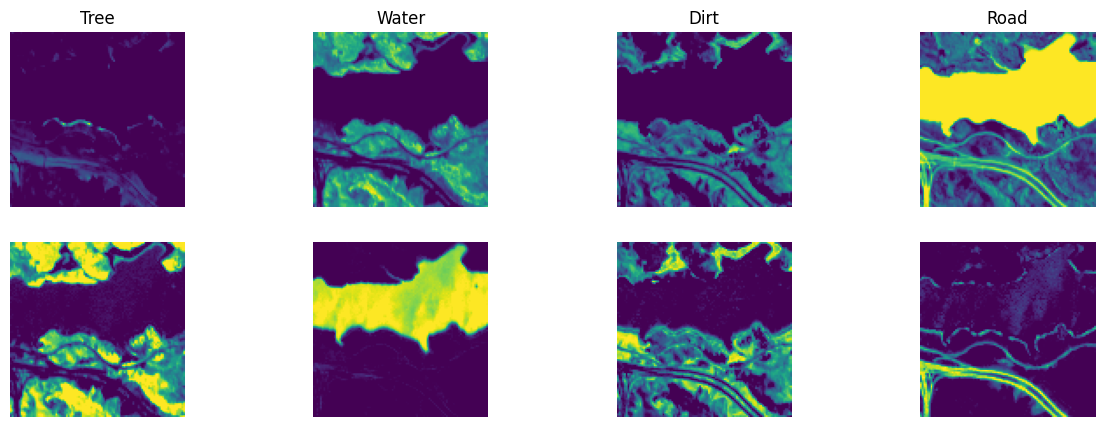

Epoch: 3000/3000, Loss: 0.0261533260345459, mae: 0.371347039937973


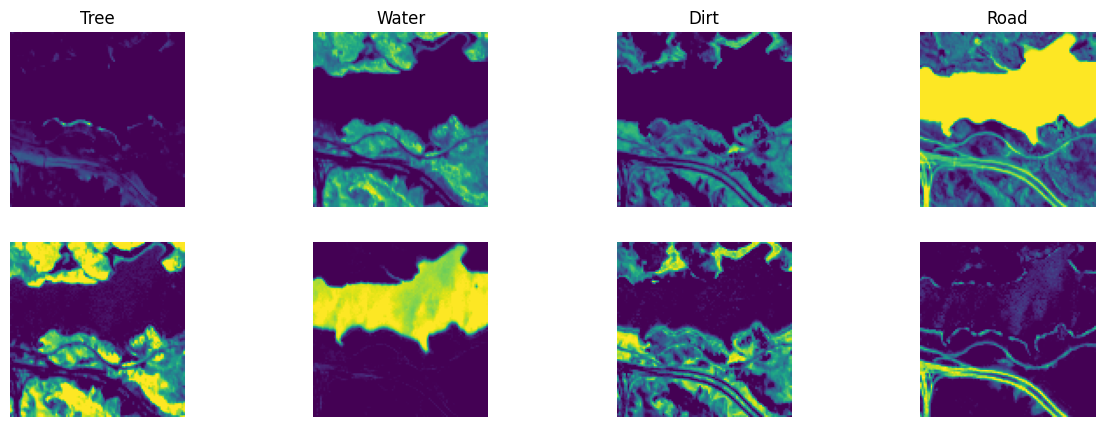

In [7]:
# Set hyperparameters
learning_rate = 0.001
num_iterations = 3000
if(dataset==0):
    output_frames = "urban_output/urban_frames"
if(dataset==1):
    output_frames = "jasper_output/jasper_frames"
if(dataset==2):
    output_frames = "samson_output/samson_frames"
os.makedirs(output_frames, exist_ok=True)

# Prepare the data
# Assuming you have already loaded 'X' and 'abundances' from the given data
X, abundances, endmembers, p, n, r, names= load_dataset(dataset)
nCol = np.sqrt(n).astype(int)
nRow = np.sqrt(n).astype(int)

# Convert the data to PyTorch tensors
Y_tensor = torch.from_numpy(X).float().to(device)
print(Y_tensor.size())
abundances_tensor = torch.from_numpy(abundances).float().to(device)
print(abundances_tensor.size())
endmember_tensor = torch.from_numpy(endmember_atgp).float().to(device)
print(endmember_tensor.size())


# Create an instance of the UnmixingNet
model = UnmixingNet(r, nRow%2==1)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mean_absolute_error = nn.L1Loss()
mean_absolute_error.to(device)

print(criterion(endmember_tensor @ abundances_tensor, Y_tensor).item())

loss_array = []
ab_mae = []
out_avg = None

# Generate a random image as input for abundance estimation
random_image = torch.rand(1,r,nCol,nRow, device=device).float()
# Training loop
for epoch in range(num_iterations):

    # Estimate abundances using the network and endmembers
    predicted_abundances = model(random_image)

    # Compute the loss using the predicted abundances, endmembers, and ground truth image
    tmp_ab = predicted_abundances.reshape(r, n).to(device)
    
    if out_avg is None:
        out_avg = tmp_ab
    else:
        out_avg =  out_avg * 0.99 + tmp_ab * 0.01
        #out_avg =  tmp_ab 
    Xhat = endmember_tensor @ tmp_ab
    Xhat.to(device)
    loss = criterion(Xhat, Y_tensor)
    mae = mean_absolute_error(out_avg, abundances_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Create the subplots without displaying them
    fig, axes = plt.subplots(2, r, figsize=(15, 5))

    # Print the loss for every 100 iterations
    file_name = f"frame_{epoch+1:04}.png"
    for ii in range(r): 
        axes[0][ii].imshow(out_avg.detach().cpu().numpy()[ii, :].reshape(nCol, nRow))
        axes[1][ii].imshow(abundances[ii,:].reshape(nCol,nRow))
        axes[0][ii].set_title(names[ii])
        axes[0][ii].axis('off')  # Turn off the axis labels and ticks
        axes[1][ii].axis('off')  # Turn off the axis labels and ticks
    plt.savefig(os.path.join(output_frames, file_name))
    
    if((epoch + 1) % 300 == 0):
        print(f"Epoch: {epoch+1}/{num_iterations}, Loss: {loss.item()}, mae: {mae.item()}")
        plt.show()
    
    plt.close()
        
    
    loss_array.append(loss.item())
    ab_mae.append(mae.item())
    

estimated_abundances_urban = model(random_image).detach().cpu().numpy()

# You can access the estimated abundances as a numpy array using estimated_abundances.detach().numpy()



(4, 10000)
0.2456362000919565
0.2456058455698121


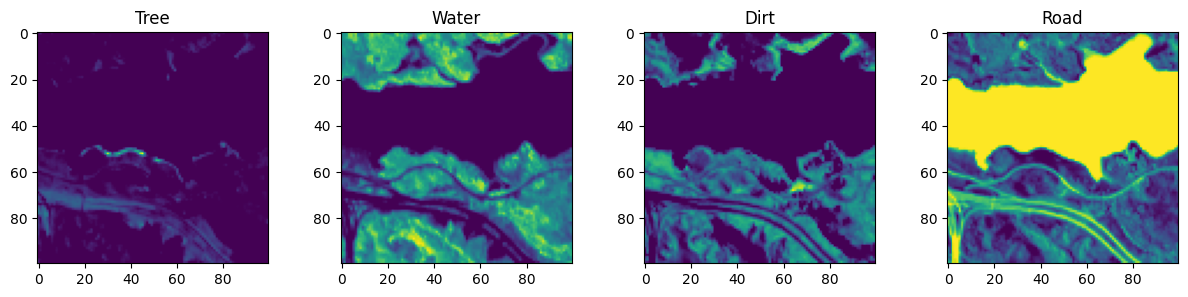

In [8]:
est=out_avg.detach().cpu().numpy().reshape(r,n)
print(est.shape)
plt.figure(figsize=(15, 3))

for ii in range(r): 
    ax = plt.subplot(1, r, ii+1)
    ax.imshow(est[ii].reshape(nCol, nRow))
    plt.title(names[ii])

diff = Xx - endmembers @ est
sum = np.sqrt(np.sum(diff**2)/(n*p))
print(sum)
diff = Xx - endmembers @ estimated_abundances_urban[0].reshape(r,n)
sum = np.sqrt(np.sum(diff**2)/(n*p))
print(sum)

In [12]:

# Generate video from frames
if(dataset==0):
    output_video = "urban_output/urban_video.mp4"
    output_dir = "urban_output/urban_frames"
if(dataset==1):
    output_video = "jasper_output/jasper_video.mp4"
    output_dir = "jasper_output/jasper_frames"
if(dataset==2):
    output_video = "samson_output/samson_video.mp4"
    output_dir = "samson_output/samson_frames"

    
frame_files = sorted(os.listdir(output_dir))
frame_paths = [os.path.join(output_dir, file) for file in frame_files]

# Load the first frame to get the frame size
frame = cv2.imread(frame_paths[0])
height, width, _ = frame.shape

# Create a VideoWriter object to write the frames to a video file
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video, fourcc, 24, (width, height))

# Write each frame to the video file
for frame_path in frame_paths:
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# Release the VideoWriter and clean up
video_writer.release()
cv2.destroyAllWindows()




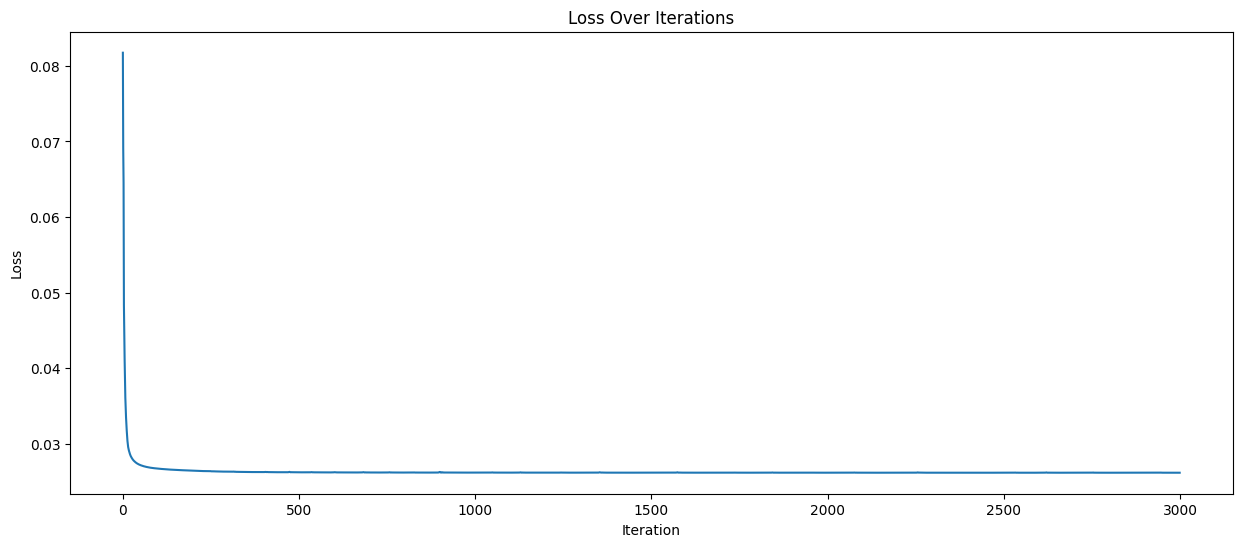

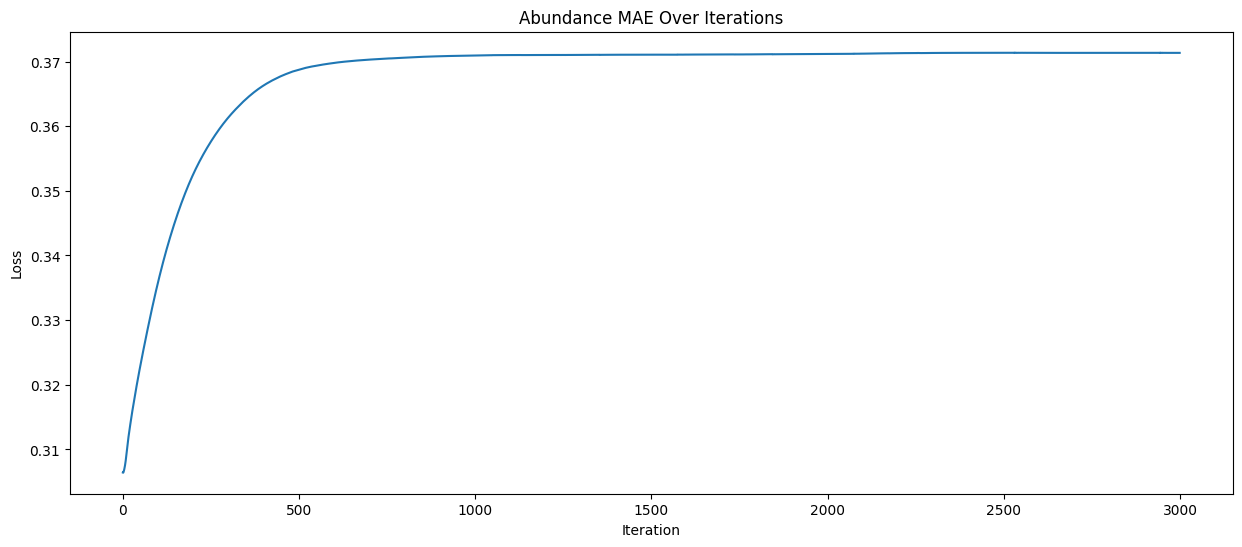

In [10]:

if(dataset==0):
    output_dir = "urban_output"
if(dataset==1):
    output_dir = "jasper_output"
if(dataset==2):
    output_dir = "samson_output"

plt.figure(figsize=(15, 6))

plt.plot(loss_array)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Iterations')
plt.savefig(os.path.join(output_dir, "Loss_Over_Iterations.png"))
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(ab_mae)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Abundance MAE Over Iterations')
plt.savefig(os.path.join(output_dir, "Abundance_MAE_Over_Iterations.png"))
plt.show()